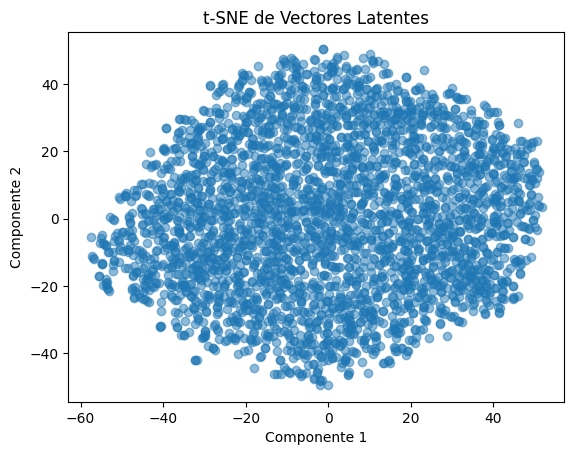

In [5]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Función para agregar ruido "Salt and Pepper" a las imágenes
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    total_pixels = image.size
    salt_pixels = int(salt_prob * total_pixels)
    pepper_pixels = int(pepper_prob * total_pixels)
    
    # Añadir 'sal' (píxeles blancos)
    for _ in range(salt_pixels):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        noisy_image[i, j] = 255
    
    # Añadir 'pimienta' (píxeles negros)
    for _ in range(pepper_pixels):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        noisy_image[i, j] = 0
    
    return noisy_image

# Función para cargar imágenes de una carpeta
def load_images_from_folder(folder_path):
    images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (28, 28))  # Redimensionar a 28x28
                images.append(image)
    return np.array(images)

# Cargar imágenes de las carpetas TRAIN, TEST y VALID
train_images = load_images_from_folder('archive/TRAIN')
test_images = load_images_from_folder('archive/TEST')
valid_images = load_images_from_folder('archive/VALID')

# Unir todas las imágenes cargadas
all_images = np.concatenate([train_images, test_images, valid_images], axis=0)

# Añadir ruido "Salt and Pepper" a las imágenes
images_noisy = np.array([add_salt_and_pepper_noise(img, 0.1, 0.1) for img in all_images])
images_noisy = images_noisy.reshape(len(images_noisy), -1) / 255.0

# Definición del Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Inicializar el modelo
autoencoder = DenoisingAutoencoder()

# Convertir imágenes a tensores
images_tensor = torch.FloatTensor(images_noisy)
encoded_images = autoencoder.encoder(images_tensor).detach().numpy()

# Visualización del espacio latente con t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(encoded_images)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("t-SNE de Vectores Latentes")
plt.show()



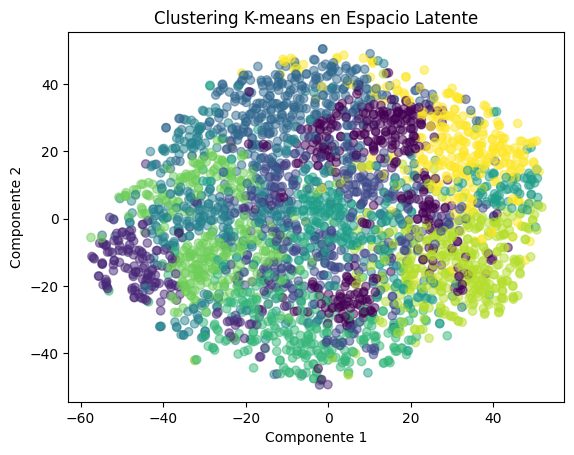

In [6]:
# Clustering con K-means
kmeans = KMeans(n_clusters=10, random_state=0)  # Ajusta el número de clusters según sea necesario
labels = kmeans.fit_predict(encoded_images)

# Visualización del clustering
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="viridis", alpha=0.5)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("Clustering K-means en Espacio Latente")
plt.show()